# Test functions for cross correlations
Cross- correlation is defined as the normalized cross covariance $K_{XY}$

\begin{align*}
K_{X,Y}(\tau) &= \mathbb{E}[(X_{t}-\mu_{X})(Y_{t+\tau}-\mu_{Y}) ] \\
              &= \frac{\sum_i (x_i-\overline{x})(y_i-\overline{y} )}{N} \\
              &= \frac{\sum_i x_i y_i}{N} - \overline{x}\overline{y}.
\end{align*}
Note that $N$ is the length of the overlapping segment between the series $X_t$ and $Y_{t+\tau}$.

Cross-correlation is then defined as
$$
\rho_{XY}(\tau) =  \frac{K_{X,Y}(\tau)}{\sigma_X \sigma_Y},
$$
in this way it can be interpreted as a $\tau$-varying Pearson correlation coefficient.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided


### Functions definition

In [140]:
def cross_correlation_exact(x,y,maxlag=3,normalize=True):
    # Slow version with for loops

    lag_list = np.arange(-maxlag,maxlag+1,step=1)
    cc = np.full(len(lag_list),np.nan)

    for idx,tau in enumerate(lag_list):
        # print(tau)
        shift = np.abs(tau)
        if tau < 0:
            yt = y[shift:]
            xt = x[:-shift]
        elif tau >0:
            yt = y[:-shift]
            xt = x[shift:]
        elif tau == 0:
            yt = y
            xt = x
        
        # Cross-covariance
        cc[idx] = xt.dot(yt)/len(xt) - np.mean(xt)*np.mean(yt)


        if normalize:
            cc[idx] /= (np.std(xt)*np.std(yt))
            # cc[idx]  =  (xt.dot(yt)/len(xt) - np.mean(xt)*np.mean(yt))/ (np.std(xt)*np.std(yt))
        # else:
        #     cc[idx] = xt.dot(yt)  # Just the dot product
        
        cmax = cc.max()

    return cmax, cc


def cross_correlation_exact_fast(x, y,maxlag=3,normalize=True):
    # Fast version: compute dot product with numpy, normalize just the max

    lag_list = np.arange(-maxlag,maxlag+1,step=1)
    cc = np.full(len(lag_list),np.nan)

    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')

    
    cc = T.dot(px)

    cmax = float(cc.max())


    if normalize:

        lag_max = lag_list[np.argmax(cc)]
        shift = np.abs(lag_max)
        if lag_max < 0:
            yt = y[shift:]
            xt = x[:-shift]
        elif lag_max >0:
            yt = y[:-shift]
            xt = x[shift:]
        elif lag_max == 0:
            yt = y
            xt = x
        cmax = cmax/len(xt) - np.mean(xt)*np.mean(yt)

    return cmax, cc



def crosscorrelation(x, y, maxlag, normalize=True):
    """
    Cross correlation with a maximum number of lags, with optional normalization.

    Parameters:
    x, y: one-dimensional numpy arrays with the same length.
    maxlag: maximum lag for which the cross correlation is computed.
    normalize: if True, calculate the normalized cross-correlation.
    
    Returns:
    An array of cross-correlation values with length 2*maxlag + 1.
    
    Credits: 
    https://stackoverflow.com/questions/30677241/how-to-limit-cross-correlation-window-width-in-numpy
    
    """
    
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')

    
    cross_corr = T.dot(px)
    
    '''if normalize:
        # Subtract means
        mx = np.mean(x)
        my = np.mean(y)
        norm = float(len(y) * mx * my)

        # Compute the numerator as the sum of products of differences from means
        numerator = cross_corr - norm

        # Compute the denominator
        sigma_x = np.sqrt(np.sum((x - mx) ** 2))
        sigma_y = np.sqrt(np.sum((y - my) ** 2))
        denominator = float(sigma_x * sigma_y)
        
        # Normalize the cross-correlation
        cross_corr = numerator / denominator'''

    cmax = float(cross_corr.max())

    if normalize:
        mx = np.mean(x)
        my = np.mean(y)
        norm = float(len(y) * mx * my)

        
        numerator = cmax - norm

        sigma_x = np.sqrt(np.sum((x - mx) ** 2))
        sigma_y = np.sqrt(np.sum((y - my) ** 2))
        denominator = float(sigma_x * sigma_y)
        
        cmax = numerator / denominator

        cross_corr /= ( sigma_x * sigma_y)

    return cmax, cross_corr
    



### Generate two random series with some cross correlation

In [126]:
np.random.seed(2304)  # For reproducibility
N = int(1e2)
x = np.cos(np.arange(N)) + np.random.randn(N)
y = np.sin(np.arange(N)) + np.random.randn(N)

In [132]:
cmax, cc = cross_correlation_exact(x,y,maxlag=10, normalize=True)
cmax_app, cc_app = crosscorrelation(x,y,maxlag=10, normalize=True)
cmax_exact_fast = cross_correlation_exact_fast(x,y,maxlag=10,normalize=True)
print(f"Valore esatto: {cmax}")
print(f"Valore esatto fast: {cmax}")
print(f"Valore approssimato: {cmax_app}")

Valore esatto: 0.30508325377573253
Valore esatto fast: 0.30508325377573253
Valore approssimato: 0.2992570985996778


### Performance

In [135]:
%%timeit
cmax, cc = cross_correlation_exact(x,y,maxlag=10)

443 µs ± 8.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [134]:
%%timeit
cmax_app = crosscorrelation(x,y,maxlag=10)

42.4 µs ± 470 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [133]:
%%timeit
cmax_app = cross_correlation_exact_fast(x,y,maxlag=10)

42 µs ± 1.62 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Plot to check perfect match

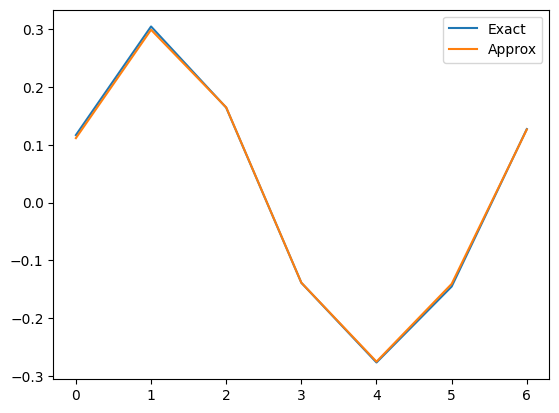

In [141]:
# x = np.array([2, 1.5, 0, 0, -1, 3, 2, -0.5])
# y = np.arange(8)
# np.correlate(x, x, mode='full')[7:11]


cmax, cc_ext = cross_correlation_exact(x, y, maxlag=3, normalize=True)
cmax_app, cc_app = crosscorrelation(x,y,maxlag=3,normalize=True)
# print(np.correlate(x, y, mode='full')[4:11])


plt.plot(cc_ext, label = 'Exact')
plt.plot(cc_app, label = 'Approx')
plt.legend()

In [137]:
cross_correlation_exact(x, y, maxlag=3, normalize=True)

(0.30508325377573253,
 array([ 0.11699489,  0.30508325,  0.16455191, -0.138874  , -0.276942  ,
        -0.14542849,  0.12739688]))

In [139]:
cmax_app, cc_app = crosscorrelation(x,y,maxlag=3,normalize=True)

In [ ]:
cc_numpy = np.correlate(x,y,mode="full")
cmax, cc = cross_correlation_exact(x,y,maxlag=N, normalize=False)
plt.plot(cc, label = "Exact")
plt.plot(cc_numpy, label= "Numpy")